In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import math
from typing import List

## Load sample and extract patterns

In [2]:
pixels = [[255, 255, 255, 255], [255, 0, 0, 0], [255, 0, 138, 0], [255, 0, 0, 0]]
input_size = (4, 4)
output_size = (50, 50)

[[255, 255, 255, 255], [255, 0, 0, 0], [255, 0, 138, 0], [255, 0, 0, 0]]


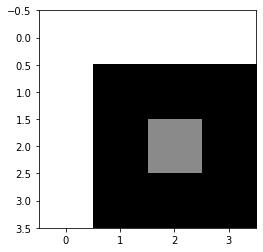

In [3]:
plt.imshow(pixels, cmap="gray") # create plt
print(pixels)
plt.show()

In [4]:
class Pattern:
    def __init__(self, pixels):
        self.pixels = pixels
        
    def __len__(self):
        return 1

In [5]:
def get_all_rotations(pixelMatrix):
    """
    Return original array as well as rotated by 90, 180 and 270 degrees in the form of tuples
    """
    pixelMatrix_rotated_1 = [[pixelMatrix[j][i] for j in range(len(pixelMatrix))] for i in range(len(pixelMatrix[0])-1,-1,-1)]
    pixelMatrix_rotated_2 = [[pixelMatrix_rotated_1[j][i] for j in range(len(pixelMatrix_rotated_1))] for i in range(len(pixelMatrix_rotated_1[0])-1,-1,-1)]
    pixelMatrix_rotated_3 = [[pixelMatrix_rotated_2[j][i] for j in range(len(pixelMatrix_rotated_2))] for i in range(len(pixelMatrix_rotated_2[0])-1,-1,-1)]
    return tuple(tuple(row) for row in pixelMatrix), \
            tuple(tuple(row) for row in pixelMatrix_rotated_1), \
            tuple(tuple(row) for row in pixelMatrix_rotated_2), \
            tuple(tuple(row) for row in pixelMatrix_rotated_3)

N = 2 # pattern size
patterns = []
weights = {} # dict pattern -> occurence
probability = {} # dict pattern -> probability
for y in range(input_size[0]-(N-1)): # row 
    for x in range(input_size[1]-(N-1)): # column
        pattern = []
        for k in pixels[y:y+N]:
            pattern.append([int(i) for i in k[x:x+N]]) # change array to int really quick
        pattern_rotations = get_all_rotations(pattern)
        
        for rotation in pattern_rotations:
            if rotation not in weights:
                weights[rotation] = 1
            else:
                weights[rotation] += 1
        
        patterns.extend(pattern_rotations)
        
# remove duplicates
patterns_without_duplicates = []
for patt in patterns:
    if patt not in patterns_without_duplicates:
        patterns_without_duplicates.append(patt)
patterns = patterns_without_duplicates

sum_of_weights = 0
for weight in weights:
    sum_of_weights += weights[weight]

for pattern in patterns:
    probability[pattern] = weights[pattern] / sum_of_weights
    
# convert patterns from tuples into Pattern objects
patterns = [Pattern(p) for p in patterns]
weights = {pattern:weights[pattern.pixels] for pattern in patterns}
probability = {pattern:probability[pattern.pixels] for pattern in patterns}

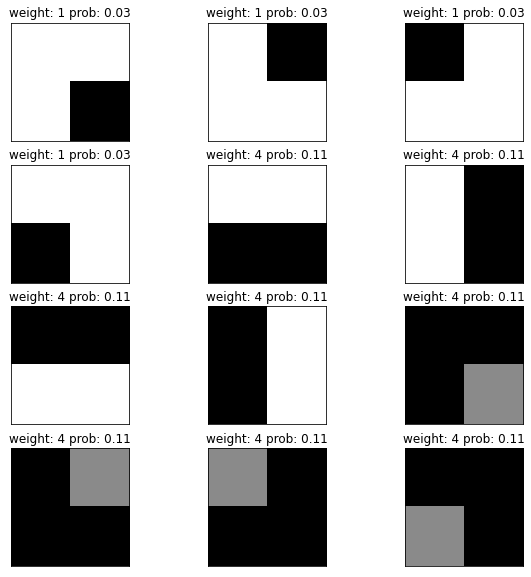

In [6]:
# show 
plt.figure(figsize=(10,10))
for m in range(len(patterns)):
    axs = plt.subplot(4, math.ceil(len(patterns)/4), m+1)
    axs.imshow(patterns[m].pixels, cmap="gray", vmin=0, vmax=255)
    axs.set_xticks([])
    axs.set_yticks([])
    plt.title("weight: %.0f prob: %.2f"%(weights[patterns[m]], probability[patterns[m]]))
plt.show()

## Create Index data structure describing rules for placing patterns

In [7]:
UP = (0, -1)
LEFT = (-1, 0)
DOWN = (0, 1)
RIGHT = (1, 0)
UP_LEFT = (-1, -1)
UP_RIGHT = (1, -1)
DOWN_LEFT = (-1, 1)
DOWN_RIGHT = (1, 1)
dirs = [UP, DOWN, LEFT, RIGHT, UP_LEFT, UP_RIGHT, DOWN_LEFT, DOWN_RIGHT]

def valid_dirs(pos):
    x, y = pos
    
    valid_directions = []

    if x == 0:
        valid_directions.extend([RIGHT])
        if y == 0:
            valid_directions.extend([DOWN, DOWN_RIGHT])
        elif y == output_size[1]-1:
            valid_directions.extend([UP, UP_RIGHT])
        else:
            valid_directions.extend([DOWN, DOWN_RIGHT, UP, UP_RIGHT])
    elif x == output_size[0]-1:
        valid_directions.extend([LEFT])
        if y == 0:
            valid_directions.extend([DOWN, DOWN_LEFT])
        elif y == output_size[1]-1:
            valid_directions.extend([UP, UP_LEFT])
        else:
            valid_directions.extend([DOWN, DOWN_LEFT, UP, UP_LEFT])
    else:
        valid_directions.extend([LEFT, RIGHT])
        if y == 0:
            valid_directions.extend([DOWN, DOWN_LEFT, DOWN_RIGHT])
        elif y == output_size[1]-1:
            valid_directions.extend([UP, UP_LEFT, UP_RIGHT])
        else: 
            valid_directions.extend([UP, UP_LEFT, UP_RIGHT, DOWN, DOWN_LEFT, DOWN_RIGHT])
    
    return valid_directions

In [8]:
class Index:
    """
    Tells which combinations of patterns are allowed for all patterns
    
    data (dict):
        pattern -> posible_connections (dict):
                    relative_position -> patterns (list)
    """
    
    def __init__(self, patterns: List[Pattern]):
        self.data = {}
        for pattern in patterns:
            self.data[pattern] = {}
            for d in dirs: 
                self.data[pattern][d] = []
    
    def add_rule(self, pattern: Pattern, relative_position: tuple, next_pattern: Pattern):
        self.data[pattern][relative_position].append(next_pattern)
        
        
    def check_possibility(self, pattern: Pattern, check_pattern: Pattern, relative_pos: tuple):
        if isinstance(pattern, list):
            pattern = pattern[0]
            
        return check_pattern in self.data[pattern][relative_pos]

index = Index(patterns)

In [9]:
def get_offset_tiles(pattern: Pattern, offset: tuple):
    if offset == (0, 0):
        return pattern.pixels
    if offset == (-1, -1):
        return tuple([pattern.pixels[1][1]])
    if offset == (0, -1):
        return tuple(pattern.pixels[1][:])
    if offset == (1, -1):
        return tuple([pattern.pixels[1][0]])
    if offset == (-1, 0):
        return tuple([pattern.pixels[0][1], pattern.pixels[1][1]])
    if offset == (1, 0):
        return tuple([pattern.pixels[0][0], pattern.pixels[1][0]])
    if offset == (-1, 1):
        return tuple([pattern.pixels[0][1]])
    if offset == (0, 1):
        return tuple(pattern.pixels[0][:])
    if offset == (1, 1):
        return tuple([pattern.pixels[0][0]])

In [10]:
# Generate rules for Index and save them
rules_num = 0
for pattern in patterns:
    for d in dirs:
        for pattern_next in patterns:
            # here's checking all offsets 
            overlap = get_offset_tiles(pattern_next, d)
            og_dir = tuple([d[0]*-1, d[1]*-1])
            part_of_og_pattern = get_offset_tiles(pattern, og_dir)
            if (overlap) == (part_of_og_pattern):
                index.add_rule(pattern, d, pattern_next)
                rules_num+=1

In [21]:
# # Show data in Index
# print(f"There are {rules_num} rules")

# for d in index.data:
#     print(f'Pattern {d.pixels}')
#     for pos in index.data[d]:
#         print(f' Pos {pos}')
#         for pattern in index.data[d][pos]:
#             print(f' {pattern.pixels}')

## Define coefficients

In [12]:
def initialize_wave_function(size):
    """
    Initialize wave function of the size 'size' where in each tile no patterns are foridden yet.
    Coefficients describe what patterns can occur in each tile. At the beggining, at every possition there is full set
    of patterns available
    """
    
    coefficients = []
    
    for col in range(size[0]):
        row = []
        for r in range(size[1]):
            row.append(patterns)
        coefficients.append(row)
    return coefficients

coefficients = initialize_wave_function(output_size)

## Utility functions

In [13]:
def is_fully_collapsed():
    """
    Check if wave function is fully collapsed meaning that for each tile available is only one pattern
    """
    for col in coefficients:
        for entry in col:
            if(len(entry)>1):
                return False
    return True

In [14]:
def get_possible_patterns_at_position(position):
    """
    Return possible patterns at position (x, y)
    """
    x, y = position
    possible_patterns = coefficients[x][y]
    return possible_patterns

In [15]:
def get_shannon_entropy(position):
    """
    Calcualte the Shannon Entropy of the wavefunction at position (x, y)
    """
    x, y = position
    entropy = 0
    
    # A cell with one valid pattern has 0 entropy
    if len(coefficients[x][y]) == 1:
        return 0
    
    for pattern in coefficients[x][y]:
        entropy += probability[pattern] * math.log(probability[pattern], 2)
    entropy *= -1
    
    # Add noise to break ties and near-ties
    entropy -= random.uniform(0, 0.1)
    return entropy

In [16]:
def get_min_entropy_pos():
    """
    Return position of tile with the lowest entropy
    """
    minEntropy = None
    minEntropyPos = None
    
    for x, col in enumerate(coefficients):
        for y, row in enumerate(col):
            entropy = get_shannon_entropy((x, y))
            
            if entropy == 0:
                continue
            
            if minEntropy is None or entropy < minEntropy:
                minEntropy = entropy
                minEntropyPos = (x, y)
    return minEntropyPos

## Algorithm itself

In [17]:
def observe():
    # Find the lowest entropy
    min_entropy_pos = get_min_entropy_pos()
    
    if min_entropy_pos == None:
        print("All tiles have 0 entropy")
        return
    
    # Choose a pattern at lowest entropy position which is most frequent in the sample
    possible_patterns = get_possible_patterns_at_position(min_entropy_pos)
    
    # calculate max probability for patterns that are left
    max_p = 0
    for pattern in possible_patterns:
        if max_p < probability[pattern]:
            max_p == probability[pattern]
    
    
    semi_random_pattern = random.choice([pat for pat in possible_patterns if probability[pat]>=max_p])
    
    # Set this pattern to be the only available at this position
    coefficients[min_entropy_pos[0]][min_entropy_pos[1]] = semi_random_pattern
    
    return min_entropy_pos

In [18]:
def propagate(min_entropy_pos):
    stack = [min_entropy_pos]
    
    
    while len(stack) > 0:
        pos = stack.pop()
        
        possible_patterns = get_possible_patterns_at_position(pos)
        
        # Iterate through each location immediately adjacent to the current location
        for d in valid_dirs(pos):
            adjacent_pos = (pos[0] + d[0], pos[1] + d[1])
            possible_patterns_at_adjacent = get_possible_patterns_at_position(adjacent_pos)
            
            # Iterate over all still available patterns in adjacent tile 
            # and check if pattern is still possible in this location
            if not isinstance(possible_patterns_at_adjacent, list):
                possible_patterns_at_adjacent = [possible_patterns_at_adjacent]
            for possible_pattern_at_adjacent in possible_patterns_at_adjacent:
                if len(possible_patterns) > 1:
                    is_possible = any([index.check_possibility(pattern, possible_pattern_at_adjacent, d) for pattern in possible_patterns])
                else:
                    is_possible = index.check_possibility(possible_patterns, possible_pattern_at_adjacent, d)
                    
                """
                If the tile is not compatible with any of the tiles in the current location's wavefunction
                then it's impossible for it to ever get choosen so it needs to be removed from the other
                location's wavefunction
                """
                if not is_possible:
                    x, y = adjacent_pos
                    coefficients[x][y] = [patt for patt in coefficients[x][y] if patt.pixels != possible_pattern_at_adjacent.pixels]
                        
                    if adjacent_pos not in stack:
                        stack.append(adjacent_pos)

In [19]:
while not is_fully_collapsed():
    min_entropy_pos = observe()
    propagate(min_entropy_pos)

## Post process

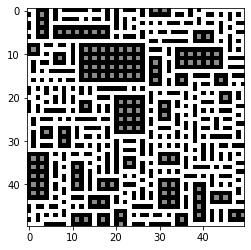

In [20]:
final_pixels = []

for i in coefficients:
    row = []
    for j in i:
        if isinstance(j, list):
            first_pixel = j[0].pixels[0][0]
        else:
            first_pixel = j.pixels[0][0]
        row.append(first_pixel)
    final_pixels.append(row)
    
plt.imshow(final_pixels, cmap="gray")
plt.show()